# Fine-tuning SAM on Satellite Images for Street Segmentation

Our approach is based on reusing the pretrained SAM Vision Transformer, more specifically using the image encoder and discarding the prompt encoder and mask decoder. 

Instead we will try out a combination of different Custom Encoder thats we use on the encoded images. 

We will try to use different approaches for the Decocer: 

1. Conv/Deconv based approach
2. Fully connected MLP's
3. Same as the mask decoder? 
4. Transformer, ViT? 

Another idea is to use adapter finetuning ?

Furthermore things that can be modified are how many last layers of the SAM encoder are also fine tuned? 
Possibly just finetune them, after a while of training the newly initialized decoder. 

We will work with a lr schedule that reduces on plateau.


---
### Loss function: 
We use combination of the following: 
- DiceLoss
- FocalLoss
- BCEWithLogitsLoss
---
### Learning rate:
- really small values
- reduceLROnPlateau(optimizer, 'max', patience=reduce_patience, verbose=verbose, factor=reduce_factor)
- cosine annealing


TODO: 

- IMPLEMENT LR SCHEDULE AND STOPPING CRITERIA
- CHECK OUT OTHER DECODERS SegFormer, MLP ... 
- CHECK OUT TO TRAIN MORE LAYERS OF TRANSFORMER

# Novel Ideas:

- LOOK AT VIT ARCHITECTURE
- TRAIN FROM SCRATCH, VARIE SOMETHING WITH LOCAL/GLOBAL ATTENTION or try some COMBINATION RESIDUAL/SKIP CONNECTIONS.



In [1]:
import torch
import numpy as np
import random

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True


## Loading the dataset

In [2]:
# written by Jannek Ulm 16.5.2024
# code was inspired by the following sources: https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb

from utils.image_loading import * 
from utils.torch_device import *
from custom_datasets import Sat_Mask_Dataset, Sat_Only_Image_Dataset

device = get_torch_device(allow_mps=True)
print("using device:",device)

###########

original_data = {}
original_data["images"] =load_training_images()
original_data["masks"] = load_groundtruth_images()

city_names = ["boston","nyc","zurich","philadelphia"]
custom_data = {"images":[],"masks":[]} # stores images and gt masks

for name in city_names:
    custom_data["images"].extend(load_training_images(name))
    custom_data["masks"].extend(load_groundtruth_images(name))

custom_data["images"] = custom_data["images"]#[0:200]
custom_data["masks"] = custom_data["masks"]#[0:200]

assert (len(custom_data["images"]) == len(custom_data["masks"]))


print("the raw custom dataset contains",len(custom_data["images"]),"images")

print("custom ds: (min,mean,max) street ratio",get_street_ratio_mmm(custom_data["masks"]))
print("orig ds: (min,mean,max) street ratio",get_street_ratio_mmm(original_data["masks"]))

# create a dataset
custom_data_set = Sat_Mask_Dataset(custom_data["images"], custom_data["masks"],min_street_ratio=0.03,max_street_ratio=1.0)
original_data_set = Sat_Mask_Dataset(original_data["images"],original_data["masks"])
print("after cleanup, the dataset now contains",len(custom_data_set),"images")


# submission kaggle dataset

kaggle_submission_images = load_test_images()
submission_data_set = Sat_Only_Image_Dataset(kaggle_submission_images)


using device: cuda:0
the raw custom dataset contains 12457 images
custom ds: (min,mean,max) street ratio (0.0, 0.13104875371277272, 0.72180625)
orig ds: (min,mean,max) street ratio (0.008968750000000001, 0.17797695312500006, 0.40426875)
Initialzed dataset, checked for min,max street ratio. Discarded %: 0.11383158063739263  num discarded: 1418
Initialzed dataset, checked for min,max street ratio. Discarded %: 0.0  num discarded: 0
after cleanup, the dataset now contains 11039 images


In [3]:
dataset = custom_data_set
print(dataset[0][0].shape, dataset[0][0].dtype, dataset[0][0].mean(), dataset[0][0].min(), dataset[0][0].max())
print(dataset[0][1].shape, dataset[0][1].dtype, dataset[0][1].mean(), dataset[0][1].min(), dataset[0][1].max())

torch.Size([3, 1024, 1024]) torch.float32 tensor(133.7138) tensor(1.) tensor(254.)
torch.Size([1, 1024, 1024]) torch.float32 tensor(0.3802) tensor(0.) tensor(1.)


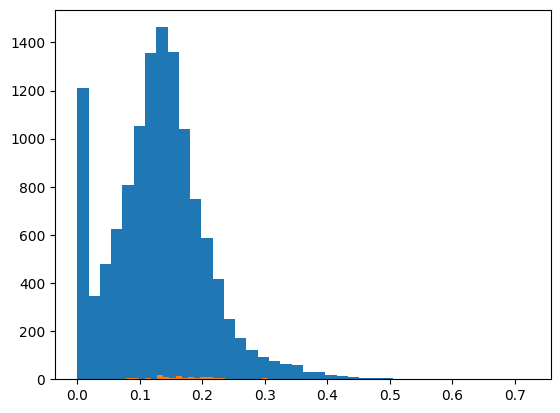

In [4]:
# plot the street ratio distribution of the dataset

custom_ratios = get_street_ratio_distr(custom_data["masks"])
original_ratios = get_street_ratio_distr(original_data["masks"])

plt.hist(custom_ratios,40)
plt.hist(original_ratios,40)
plt.show()

img:  (1024, 1024, 3) uint8 1 254 133.7029275894165
mask2:  (1024, 1024, 1) uint8 0 255
cmb:  (1024, 1024, 3) uint8 0 255 119.07334073384602


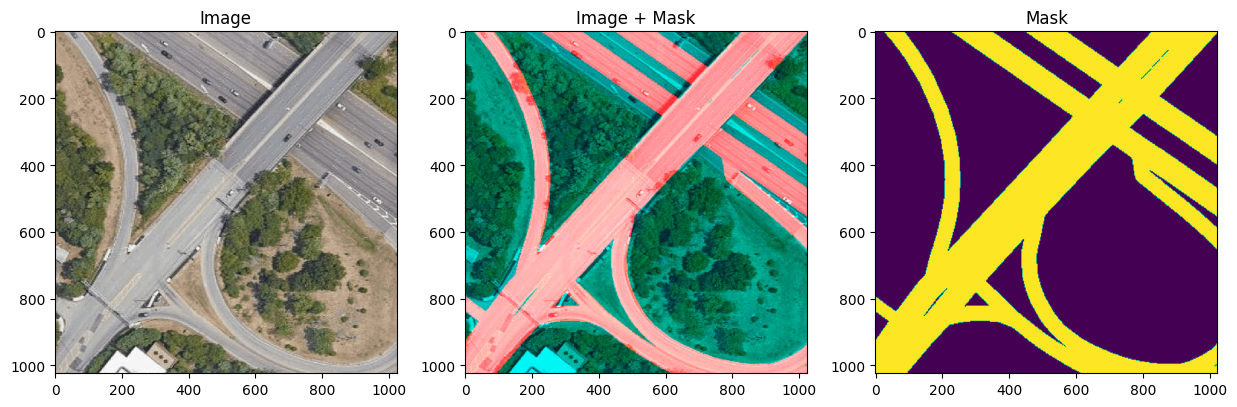

0 255 0.0 1.0


In [5]:
# make sure the dataset loading works as planned: 

import matplotlib.pyplot as plt

# get some random training images
idx = 0
image, mask = custom_data_set[idx]

img = np.array(image).astype(np.uint8)
# swap first and third dimension
img = np.swapaxes(img, 0, 2)
mask = np.array(mask)
mask = np.swapaxes(mask, 0, 2)

# 1x2 plot: 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img)

# image + mask overlay
plt.subplot(1, 3, 2)
plt.title("Image + Mask")
print("img: ",img.shape,img.dtype,img.min(),img.max(),img.mean())
mask2 = (mask * 255.).astype(np.uint8)
print("mask2: ",mask2.shape,mask2.dtype,mask2.min(),mask2.max())
cmb = img
cmb[:,:,0] = mask2[:,:,0]  
print("cmb: ",cmb.shape,cmb.dtype,cmb.min(),cmb.max(),cmb.mean())
plt.imshow(cmb)

# mask
plt.subplot(1, 3, 3)
plt.title("Mask")
plt.imshow(mask)
plt.show()
print(img.min(), img.max(), mask.min(), mask.max())


## Dataloader

In [6]:
train_split = 0.8


gpu_batch_size = 1

import torch.utils.data
custom_train_dataset, custom_test_dataset = torch.utils.data.random_split(custom_data_set, [train_split, 1-train_split])
original_train_dataset, original_test_dataset = torch.utils.data.random_split(original_data_set, [train_split, 1-train_split])


print(len(custom_train_dataset), len(custom_test_dataset))

from torch.utils.data import DataLoader


# CHECK IF THE FOR MULTIPLE NUM WORKERS THE CODE WORKS AS EXPECTED
# SEEMS TO BE CAUSING ISSUES WITH LONG startup and shutdown times for each epoch

# decided to drop last to make f1/loss score mean computation easier.

#original_train_dataloader = DataLoader(original_train_dataset, batch_size=gpu_batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)
#original_test_dataloader = DataLoader(original_test_dataset, batch_size=gpu_batch_size, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)
original_dataloader = DataLoader(original_data_set, batch_size=gpu_batch_size, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)

# dataloader for submission dataset: 
submission_dataloader = DataLoader(submission_data_set, batch_size=gpu_batch_size, shuffle=False, drop_last=False,num_workers=4,persistent_workers=True)

#custom_train_dataloader = DataLoader(custom_train_dataset, batch_size=gpu_batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)
#custom_test_dataloader = DataLoader(custom_test_dataset, batch_size=gpu_batch_size, shuffle=False, drop_last=True,num_workers=4,persistent_workers=True)
custom_dataloader = DataLoader(custom_data_set, batch_size=gpu_batch_size, shuffle=True, drop_last=True,num_workers=4,persistent_workers=True)

8832 2207


## Loading the model

In [7]:

############ (CUSTOM SAM (stored in repo))
from custom_segment_anything.segment_anything import sam_model_registry
from custom_segment_anything.segment_anything.CUSTOM_SAM import *

# load the model from checkpoints on disk:
def load_sam_decoder_model_from_checkpoint(checkpoint_idx:int, device,decoder,encoder_finetune_num_last_layers=6):
    sam_checkpoint_path = "custom_segment_anything/model_checkpoints/"
    # base, large, huge checkpoints. 
    checkpoint_names = ["vit_b","vit_l","vit_h"]
    checkpoints = ["sam_vit_b_01ec64.pth","sam_vit_l_0b3195.pth","sam_vit_h_4b8939.pth"]
    model_paths = [sam_checkpoint_path+checkpoint_name for checkpoint_name in checkpoints]
    sam = sam_model_registry[checkpoint_names[checkpoint_idx]](checkpoint=model_paths[checkpoint_idx])
    sam.to(device)
    model = SAM_Encoder_Custom_Decoder(sam.preprocess, sam.image_encoder,decoder=decoder,encoder_finetune_num_last_layers=encoder_finetune_num_last_layers)
    model = model.to(device)
    return model


# load the finetnued model state, if already started training. 
def load_finetuned_model(name,device,decoder,encoder_finetune_num_last_layers=6):
    model = load_sam_decoder_model_from_checkpoint(0,device,decoder,encoder_finetune_num_last_layers)
    finetune_path = "custom_segment_anything/model_checkpoints/finetuned/"
    model.load_state_dict(torch.load(finetune_path+name,map_location=torch.device('cpu')))
    model = model.to(device)
    return model

############################



def load_sam_model(decoder_option, device, encoder_finetune_num_last_layers, sam_checkpoint_idx=0,finetuned_model_name="model.pth",sam_checkpoint_or_finetuned="sam"):
    #   
    #   decoder_options: ["conv", "mlp" , "segformer_mlp"]
    #   encoder_finetune_num_last_layers tells how many layers of sam encoder are finetuned, all decoder layers are tuned. 
    #   sam_checkpoint_or_finetuned checks if the model is loaded from a sam checkpoint or a finetuned model with the same architecture.
    #


    # first construct the model from sam_checkpoint:

    if decoder_option == "conv":
        decoder = Conv_Decoder()
        model = load_sam_decoder_model_from_checkpoint(sam_checkpoint_idx,device,decoder.decoder,encoder_finetune_num_last_layers)
   
    elif decoder_option == "mlp":
        decoder = MLP_Decoder()
        model = load_sam_decoder_model_from_checkpoint(sam_checkpoint_idx,device,decoder,encoder_finetune_num_last_layers)

    elif decoder_option == "segformer_mlp":
        raise NotImplementedError("segformer_mlp decoder not implemented yet")
    else:
        raise ValueError("invalid decoder option")
    
    # if should load from fine-tuned model, load the model from the finetuned path.
    if sam_checkpoint_or_finetuned == "finetuned":
        finetune_path = "custom_segment_anything/model_checkpoints/finetuned/"
        model.load_state_dict(torch.load(finetune_path+finetuned_model_name+".pth",map_location=torch.device('cpu')))
    elif sam_checkpoint_or_finetuned == "sam":
        pass
        # already initialized model from sam_checkpoint
    else: 
        raise ValueError("invalid sam_checkpoint_or_finetuned option")
    
    
    # Unfreeze last layers of the encoder
    for layer_number, param in enumerate(model.sam_encoder.parameters()):
        if layer_number > 176 - encoder_finetune_num_last_layers:
            param.requires_grad = True
    
    # Unfreeze neck of the encoder
    model.sam_encoder.neck.requires_grad = True
    model.requires_grad = True
    print("Percentage of trainable parameters: ",sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))
    model = model.to(device)
    return model

# Actually loading the model

In [ ]:
finetuned_model_name = "model_best_so_far.pth"
model = load_sam_model("mlp",device,encoder_finetune_num_last_layers=0,sam_checkpoint_idx=0,finetuned_model_name=finetuned_model_name,sam_checkpoint_or_finetuned="sam")


print("Model loaded")
# how many trainable parameters does the model have?
print("Trainable parameters",sum(p.numel() for p in model.parameters() if p.requires_grad))
# how many total parameters does the model have?
print("Total parameters",sum(p.numel() for p in model.parameters()))

# percentage of trainable parameters
print("Percentage of trainable parameters: ")
print("Percentage of trainable parameters: ",sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))

In [ ]:
print(model)

In [ ]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

# Loss Functions

In [8]:

from torcheval.metrics.functional import multiclass_f1_score
import torch.nn as nn
from torchvision.ops import sigmoid_focal_loss

def mean_f1_score_from_logits(pred,mask):
    # assume both inputs have the shape (batchsize,1, h,w), where h=w=1024
    # compute the mean for all the images
    # computes the mean over the 0-th axis
    pred_classes = torch.round(torch.sigmoid(pred))
    return mean_f1_score_from_classes(mask,pred_classes)


def mean_f1_score_from_classes(preds,masks):
    
    # assume both inputs have the shape (batchsize,1, h,w), where h=w=1024
    # this computes the f1 over the whole batch, for each image in the batch alone:
    
    # first reshape the tensors
    b_size = masks.shape[0]
    f1_acc = 0.
    size = torch.prod(torch.tensor(masks.shape[1:]))
    for i in range(b_size):
        mask = masks[i]
        pred = preds[i]
        # reshape and compute f1
        f1_acc = f1_acc + multiclass_f1_score(pred.reshape((size)),mask.reshape((size)))
        
    mean_f1 = f1_acc/b_size
    return mean_f1

def dice_loss(logits,masks, smooth=1e-6):
    
    probs = torch.sigmoid(logits)
    probs_flat = probs.reshape(-1)
    masks_flat = probs.reshape(-1)
    
    intersection = (probs_flat * masks_flat).sum()
    union = probs_flat.sum() + masks_flat.sum()
    dice_coeff = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice_coeff


class_weights = torch.tensor([1./0.13]).to(device)  # Example weights: adjust based on your dataset
bce_loss = nn.BCEWithLogitsLoss(weight=class_weights)

def focal_loss(logits, masks, alpha=0.15, gamma=2.0):
    probs = torch.sigmoid(logits)
    loss = sigmoid_focal_loss(probs, masks, alpha=alpha, gamma=gamma, reduction='mean')
    return loss


def combined_loss_1(logits, masks, alpha=0.15, gamma=2.0, smooth=1e-6):
    # reshape the mask and predictions for the bce loss: 
    batch_size = logits.shape[0]
    logits_sq = logits.reshape((batch_size,1024*1024))
    mask_sq = mask.reshape((batch_size,1024*1024))
    
    return 2 * dice_loss(logits, masks, smooth=smooth) + bce_loss(logits_sq, mask_sq)

def combined_loss_2(logits, masks, alpha=0.15, gamma=2.0, smooth=1e-6):
    # reshape the mask and predictions for the bce loss: 
    batch_size = logits.shape[0]
    logits_sq = logits.reshape((batch_size,1024*1024))
    mask_sq = mask.reshape((batch_size,1024*1024))
    
    return dice_loss(logits, masks, smooth=smooth) + bce_loss(logits_sq, mask_sq)

def combined_loss_3(logits, masks, alpha=0.15, gamma=2.0, smooth=1e-6):
    # reshape the mask and predictions for the bce loss: 
    batch_size = logits.shape[0]
    logits_sq = logits.reshape((batch_size,1024*1024))
    mask_sq = mask.reshape((batch_size,1024*1024))
    
    return dice_loss(logits, masks, smooth=smooth) + 2 * bce_loss(logits_sq, mask_sq)

# Training Loop

# now add the logic 

go over all possible decoder models

train for a few epochs with only few encoder layers unlocked until the last epoch didnt improve the original loss
increase the number of layers finetuned, 
if the whole epoch didnt improve, then stop the training in general

always store the model, start each new layer round with the best of the last or second last stored model. 


In [10]:
import torch
from tqdm import tqdm
import torch.nn as nn


train_loader = custom_dataloader
test_loader = original_dataloader


########
max_num_epochs = 3


# print interval and num_steps for gradient accumulation
print_interval = len(train_loader) // 1
do_intermed_prints = False

grad_batch_size = 5

#########

decoder_options = ["conv", "mlp"]
num_layers_to_finetune = [25,65,85]
learning_rates = [0.001,0.0001, 0.00001]
loss_functions = [combined_loss_1,combined_loss_2,combined_loss_3]


##################################
# TRAINING LOOP
################################

for loss_fn_idx in range(len(loss_functions)):
    for decoder_option in decoder_options:
        for idx_layer_option in range(len(num_layers_to_finetune)):
            for epoch_counter in range(max_num_epochs):
                
                epoch_to_train = epoch_counter
                layer_option = num_layers_to_finetune[idx_layer_option]
                learning_rate = learning_rates[idx_layer_option]
                loss_fn = loss_functions[loss_fn_idx]
                
                #####################################            
                # now training this model 
                current_model_description = f"model_{loss_fn_idx+1}_{decoder_option}_decoder_finetune_last_{layer_option}_epoch_{epoch_counter}"
                print("training model:",current_model_description)
                # check if this current model description already exists, if so, load the model and skip this exact training step:
                if os.path.exists("custom_segment_anything/model_checkpoints/finetuned/"+current_model_description+".pth"):
                    print("model already exists, skipping training for this layer option")
                    continue
                # since model was not already trained
                # load the "start model from checkpoint or finetuned"
                # load the initial model from the sam checkpoint
                if idx_layer_option == 0 and epoch_counter == 0:
                    print("loading model from sam checkpoint")
                    model = load_sam_model(decoder_option,device,encoder_finetune_num_last_layers=layer_option,sam_checkpoint_idx=0,finetuned_model_name=None,sam_checkpoint_or_finetuned="sam")
                else:
                    
                    if epoch_counter == 0:
                        # now epoch 0, hence load max epoch from previous layer option
                        model_description = f"model_{loss_fn_idx+1}_{decoder_option}_decoder_finetune_last_{num_layers_to_finetune[idx_layer_option-1]}_epoch_{max_num_epochs-1}"
                    else:
                        # load the last epoch from current layer option
                        model_description = f"model_{loss_fn_idx+1}_{decoder_option}_decoder_finetune_last_{layer_option}_epoch_{epoch_counter-1}"
                    print("loading model from finetuned:",model_description)
                    model = load_sam_model(decoder_option,device,encoder_finetune_num_last_layers=layer_option,sam_checkpoint_idx=0,finetuned_model_name=model_description,sam_checkpoint_or_finetuned="finetuned")
                    
                # newly initializing the optimizer and scheduler since model was loaded new (do this for every epoch:)
                ####################################
                model.to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                print("Starting Epoch: ",epoch_counter)
                # training run: 
                model.train()
                # store running losses for the epoch and the 10% print interval
                epoch_running_loss = 0.0
                epoch_running_f1 = 0.0

                short_running_loss = 0.0
                short_running_f1 = 0.0

                step_counter = 0
                
                mini_batch_loss_accumulator = 0.0
                
                # reset the gradients: 
                optimizer.zero_grad()
                
                #########################################
                # TRAINING LOOP
                for image, mask in tqdm(train_loader):
                    step_counter += 1
                    #####################
                    # forward pass
                    image = image.to(device)
                    mask = mask.to(device)    
                    pred = model(image)
                    # compute loss and f1 score: 
                    loss = loss_fn(pred,mask)
                    
                    
                    f1_score = mean_f1_score_from_logits(pred,mask).item()
                    epoch_running_loss += loss.item()
                    epoch_running_f1 += f1_score
                    short_running_loss += loss.item()
                    short_running_f1 += f1_score

                    mini_batch_loss_accumulator += loss

                    if do_intermed_prints and step_counter % print_interval == 0:
                        print("step: ",step_counter//print_interval)
                        # print out the current losses:
                        print(f"Epoch: {epoch_counter}, step: {step_counter//print_interval}, (train) Loss: {short_running_loss/print_interval}, F1: {short_running_f1/print_interval}")
                        # and reset the short running losses
                        short_running_loss = 0.0
                        short_running_f1 = 0.0

                    ###############
                    # backward pass
                    if step_counter % grad_batch_size == 0:
                        # compute the gradients
                        mini_batch_loss_accumulator = mini_batch_loss_accumulator/grad_batch_size
                        mini_batch_loss_accumulator.backward()
                        # update the model weights
                        optimizer.step()
                        # reset the gradients
                        optimizer.zero_grad()
                        mini_batch_loss_accumulator = 0.0
                    
                
                print(f"Epoch: {epoch_counter}, (train) Loss: {epoch_running_loss/len(train_loader)}, F1: {epoch_running_f1/len(train_loader)}")
                ########################################
                # save the model in every epoch
                print("saving model:",current_model_description)
                torch.save(model.state_dict(), "custom_segment_anything/model_checkpoints/finetuned/"+current_model_description+".pth")
                #########################################
                # testing run: 
                model.eval()
                with torch.no_grad():
                    l_acc = 0.0
                    score_acc = 0.0
                    for image,mask in tqdm(test_loader):
                        image = image.to(device)
                        mask = mask.to(device)
                        pred = model(image)
                        # compute loss and f1 score: 
                        score = mean_f1_score_from_logits(pred,mask)    
                        loss =  loss_fn(pred,mask)
                        # update running loss and f1 score
                        score_acc += score.item()
                        l_acc  += loss.item()
                        # store the loss and f1 score
                    print(f"Epoch: {epoch_counter}, (test) Loss: {l_acc/len(test_loader)}, F1-Score: {score_acc/len(test_loader)}")    

            # save the model after the training run

training model: model_1_conv_decoder_finetune_last_25_epoch_0
model already exists, skipping training for this layer option
training model: model_1_conv_decoder_finetune_last_25_epoch_1
model already exists, skipping training for this layer option
training model: model_1_conv_decoder_finetune_last_25_epoch_2
model already exists, skipping training for this layer option
training model: model_1_conv_decoder_finetune_last_65_epoch_0
model already exists, skipping training for this layer option
training model: model_1_conv_decoder_finetune_last_65_epoch_1
model already exists, skipping training for this layer option
training model: model_1_conv_decoder_finetune_last_65_epoch_2
model already exists, skipping training for this layer option
training model: model_1_conv_decoder_finetune_last_85_epoch_0
model already exists, skipping training for this layer option
training model: model_1_conv_decoder_finetune_last_85_epoch_1
model already exists, skipping training for this layer option
training

100%|██████████| 11039/11039 [29:14<00:00,  6.29it/s]


Epoch: 0, (train) Loss: 2.357029642747444, F1: 0.9115791945626354
saving model: model_1_mlp_decoder_finetune_last_25_epoch_0


100%|██████████| 144/144 [00:17<00:00,  8.06it/s]


Epoch: 0, (test) Loss: 2.664953346053759, F1-Score: 0.8981458300517665
training model: model_1_mlp_decoder_finetune_last_25_epoch_1
loading model from finetuned: model_1_mlp_decoder_finetune_last_25_epoch_0
Last layer number: 176
Percentage of trainable parameters:  0.1494037358351937
Starting Epoch:  1


100%|██████████| 11039/11039 [29:06<00:00,  6.32it/s]


Epoch: 1, (train) Loss: 1.9672361307439408, F1: 0.9268323762529797
saving model: model_1_mlp_decoder_finetune_last_25_epoch_1


100%|██████████| 144/144 [00:17<00:00,  8.04it/s]


Epoch: 1, (test) Loss: 2.393923029717472, F1-Score: 0.9060503240260813
training model: model_1_mlp_decoder_finetune_last_25_epoch_2
loading model from finetuned: model_1_mlp_decoder_finetune_last_25_epoch_1
Last layer number: 176
Percentage of trainable parameters:  0.1494037358351937
Starting Epoch:  2


100%|██████████| 11039/11039 [29:25<00:00,  6.25it/s]


Epoch: 2, (train) Loss: 1.8622137389895557, F1: 0.9306692234879549
saving model: model_1_mlp_decoder_finetune_last_25_epoch_2


100%|██████████| 144/144 [00:20<00:00,  6.90it/s]


Epoch: 2, (test) Loss: 2.3908528602785535, F1-Score: 0.9026424495710267
training model: model_1_mlp_decoder_finetune_last_65_epoch_0
loading model from finetuned: model_1_mlp_decoder_finetune_last_25_epoch_2
Last layer number: 176
Percentage of trainable parameters:  0.35832932997993616
Starting Epoch:  0


100%|██████████| 11039/11039 [43:28<00:00,  4.23it/s]


Epoch: 0, (train) Loss: 1.7087005087998652, F1: 0.9361535132401058
saving model: model_1_mlp_decoder_finetune_last_65_epoch_0


100%|██████████| 144/144 [00:20<00:00,  6.98it/s]


Epoch: 0, (test) Loss: 2.1124761837224164, F1-Score: 0.9157543194790682
training model: model_1_mlp_decoder_finetune_last_65_epoch_1
loading model from finetuned: model_1_mlp_decoder_finetune_last_65_epoch_0
Last layer number: 176
Percentage of trainable parameters:  0.35832932997993616
Starting Epoch:  1


100%|██████████| 11039/11039 [42:38<00:00,  4.31it/s]


Epoch: 1, (train) Loss: 1.5734425975162165, F1: 0.9417366410189429
saving model: model_1_mlp_decoder_finetune_last_65_epoch_1


100%|██████████| 144/144 [00:19<00:00,  7.43it/s]


Epoch: 1, (test) Loss: 2.1206983290612698, F1-Score: 0.9203299404018455
training model: model_1_mlp_decoder_finetune_last_65_epoch_2
loading model from finetuned: model_1_mlp_decoder_finetune_last_65_epoch_1
Last layer number: 176
Percentage of trainable parameters:  0.35832932997993616
Starting Epoch:  2


100%|██████████| 11039/11039 [41:20<00:00,  4.45it/s]


Epoch: 2, (train) Loss: 1.5026087362175133, F1: 0.9443507675556981
saving model: model_1_mlp_decoder_finetune_last_65_epoch_2


100%|██████████| 144/144 [00:19<00:00,  7.31it/s]


Epoch: 2, (test) Loss: 1.9859523582789633, F1-Score: 0.9220554054611259
training model: model_1_mlp_decoder_finetune_last_85_epoch_0
loading model from finetuned: model_1_mlp_decoder_finetune_last_65_epoch_2
Last layer number: 176
Percentage of trainable parameters:  0.4692132704100376
Starting Epoch:  0


100%|██████████| 11039/11039 [44:44<00:00,  4.11it/s]


Epoch: 0, (train) Loss: 1.4021631507569978, F1: 0.9479124015446039
saving model: model_1_mlp_decoder_finetune_last_85_epoch_0


100%|██████████| 144/144 [00:19<00:00,  7.41it/s]


Epoch: 0, (test) Loss: 1.96169517437617, F1-Score: 0.9252790096733305
training model: model_1_mlp_decoder_finetune_last_85_epoch_1
loading model from finetuned: model_1_mlp_decoder_finetune_last_85_epoch_0
Last layer number: 176
Percentage of trainable parameters:  0.4692132704100376
Starting Epoch:  1


100%|██████████| 11039/11039 [44:45<00:00,  4.11it/s] 


Epoch: 1, (train) Loss: 1.3735641897486024, F1: 0.9489328028855737
saving model: model_1_mlp_decoder_finetune_last_85_epoch_1


100%|██████████| 144/144 [00:18<00:00,  7.65it/s]


Epoch: 1, (test) Loss: 1.9776819936103291, F1-Score: 0.9260559843646156
training model: model_1_mlp_decoder_finetune_last_85_epoch_2
loading model from finetuned: model_1_mlp_decoder_finetune_last_85_epoch_1
Last layer number: 176
Percentage of trainable parameters:  0.4692132704100376
Starting Epoch:  2


100%|██████████| 11039/11039 [42:58<00:00,  4.28it/s]


Epoch: 2, (train) Loss: 1.3561573877373148, F1: 0.9495694880868248
saving model: model_1_mlp_decoder_finetune_last_85_epoch_2


100%|██████████| 144/144 [00:18<00:00,  7.76it/s]


Epoch: 2, (test) Loss: 1.9280005267096891, F1-Score: 0.927132650381989
training model: model_2_conv_decoder_finetune_last_25_epoch_0
loading model from sam checkpoint
Last layer number: 176
Percentage of trainable parameters:  0.14235068424899752
Starting Epoch:  0


100%|██████████| 11039/11039 [33:13<00:00,  5.54it/s]


Epoch: 0, (train) Loss: 2.4294150344530023, F1: 0.9011667742225093
saving model: model_2_conv_decoder_finetune_last_25_epoch_0


100%|██████████| 144/144 [00:19<00:00,  7.47it/s]


Epoch: 0, (test) Loss: 2.443674062275224, F1-Score: 0.8926426925592952
training model: model_2_conv_decoder_finetune_last_25_epoch_1
loading model from finetuned: model_2_conv_decoder_finetune_last_25_epoch_0
Last layer number: 176
Percentage of trainable parameters:  0.14235068424899752
Starting Epoch:  1


100%|██████████| 11039/11039 [33:16<00:00,  5.53it/s]


Epoch: 1, (train) Loss: 1.8364040756724496, F1: 0.9233343938747084
saving model: model_2_conv_decoder_finetune_last_25_epoch_1


100%|██████████| 144/144 [00:19<00:00,  7.43it/s]


Epoch: 1, (test) Loss: 2.3282019773291216, F1-Score: 0.9003355614840984
training model: model_2_conv_decoder_finetune_last_25_epoch_2
loading model from finetuned: model_2_conv_decoder_finetune_last_25_epoch_1
Last layer number: 176
Percentage of trainable parameters:  0.14235068424899752
Starting Epoch:  2


100%|██████████| 11039/11039 [33:15<00:00,  5.53it/s]


Epoch: 2, (train) Loss: 1.6892245323915651, F1: 0.9297187228556593
saving model: model_2_conv_decoder_finetune_last_25_epoch_2


100%|██████████| 144/144 [00:19<00:00,  7.51it/s]


Epoch: 2, (test) Loss: 2.2216042793459363, F1-Score: 0.9078223850164149
training model: model_2_conv_decoder_finetune_last_65_epoch_0
loading model from finetuned: model_2_conv_decoder_finetune_last_25_epoch_2
Last layer number: 176
Percentage of trainable parameters:  0.35300866666683733
Starting Epoch:  0


100%|██████████| 11039/11039 [42:30<00:00,  4.33it/s]


Epoch: 0, (train) Loss: 1.5332772691798, F1: 0.9362849246139209
saving model: model_2_conv_decoder_finetune_last_65_epoch_0


100%|██████████| 144/144 [00:19<00:00,  7.45it/s]


Epoch: 0, (test) Loss: 1.9229315829773743, F1-Score: 0.9155114955372281
training model: model_2_conv_decoder_finetune_last_65_epoch_1
loading model from finetuned: model_2_conv_decoder_finetune_last_65_epoch_0
Last layer number: 176
Percentage of trainable parameters:  0.35300866666683733
Starting Epoch:  1


100%|██████████| 11039/11039 [42:32<00:00,  4.32it/s]


Epoch: 1, (train) Loss: 1.395854432695002, F1: 0.9421632300523411
saving model: model_2_conv_decoder_finetune_last_65_epoch_1


100%|██████████| 144/144 [00:19<00:00,  7.46it/s]


Epoch: 1, (test) Loss: 1.8894053976982832, F1-Score: 0.9209401081833575
training model: model_2_conv_decoder_finetune_last_65_epoch_2
loading model from finetuned: model_2_conv_decoder_finetune_last_65_epoch_1
Last layer number: 176
Percentage of trainable parameters:  0.35300866666683733
Starting Epoch:  2


100%|██████████| 11039/11039 [42:32<00:00,  4.33it/s]


Epoch: 2, (train) Loss: 1.3012599356324681, F1: 0.9460839185715586
saving model: model_2_conv_decoder_finetune_last_65_epoch_2


100%|██████████| 144/144 [00:19<00:00,  7.50it/s]


Epoch: 2, (test) Loss: 1.8515185359865427, F1-Score: 0.9241334754559729
training model: model_2_conv_decoder_finetune_last_85_epoch_0
loading model from finetuned: model_2_conv_decoder_finetune_last_65_epoch_2
Last layer number: 176
Percentage of trainable parameters:  0.4648120446548995
Starting Epoch:  0


100%|██████████| 11039/11039 [45:54<00:00,  4.01it/s]


Epoch: 0, (train) Loss: 1.196062425981128, F1: 0.9504014618403887
saving model: model_2_conv_decoder_finetune_last_85_epoch_0


100%|██████████| 144/144 [00:19<00:00,  7.44it/s]


Epoch: 0, (test) Loss: 1.7335957882718906, F1-Score: 0.9261178113520145
training model: model_2_conv_decoder_finetune_last_85_epoch_1
loading model from finetuned: model_2_conv_decoder_finetune_last_85_epoch_0
Last layer number: 176
Percentage of trainable parameters:  0.4648120446548995
Starting Epoch:  1


100%|██████████| 11039/11039 [45:52<00:00,  4.01it/s]


Epoch: 1, (train) Loss: 1.1671198004086776, F1: 0.9515423516625025
saving model: model_2_conv_decoder_finetune_last_85_epoch_1


100%|██████████| 144/144 [00:19<00:00,  7.55it/s]


Epoch: 1, (test) Loss: 1.741272650866045, F1-Score: 0.9272207286622789
training model: model_2_conv_decoder_finetune_last_85_epoch_2
loading model from finetuned: model_2_conv_decoder_finetune_last_85_epoch_1
Last layer number: 176
Percentage of trainable parameters:  0.4648120446548995
Starting Epoch:  2


100%|██████████| 11039/11039 [45:52<00:00,  4.01it/s]


Epoch: 2, (train) Loss: 1.1475955747666593, F1: 0.9522940027280739
saving model: model_2_conv_decoder_finetune_last_85_epoch_2


100%|██████████| 144/144 [00:19<00:00,  7.47it/s]


Epoch: 2, (test) Loss: 1.7066014318002596, F1-Score: 0.9274593885574076
training model: model_2_mlp_decoder_finetune_last_25_epoch_0
loading model from sam checkpoint
Last layer number: 176
Percentage of trainable parameters:  0.1494037358351937
Starting Epoch:  0


100%|██████████| 11039/11039 [30:37<00:00,  6.01it/s]


Epoch: 0, (train) Loss: 2.0555684313398093, F1: 0.9137732599921736
saving model: model_2_mlp_decoder_finetune_last_25_epoch_0


100%|██████████| 144/144 [00:18<00:00,  7.78it/s]


Epoch: 0, (test) Loss: 2.2876316958831415, F1-Score: 0.9015302455259694
training model: model_2_mlp_decoder_finetune_last_25_epoch_1
loading model from finetuned: model_2_mlp_decoder_finetune_last_25_epoch_0
Last layer number: 176
Percentage of trainable parameters:  0.1494037358351937
Starting Epoch:  1


100%|██████████| 11039/11039 [30:30<00:00,  6.03it/s]


Epoch: 1, (train) Loss: 1.700321072814624, F1: 0.928800530321994
saving model: model_2_mlp_decoder_finetune_last_25_epoch_1


100%|██████████| 144/144 [00:18<00:00,  7.77it/s]


Epoch: 1, (test) Loss: 2.2920073684718876, F1-Score: 0.9056236760483848
training model: model_2_mlp_decoder_finetune_last_25_epoch_2
loading model from finetuned: model_2_mlp_decoder_finetune_last_25_epoch_1
Last layer number: 176
Percentage of trainable parameters:  0.1494037358351937
Starting Epoch:  2


100%|██████████| 11039/11039 [30:25<00:00,  6.05it/s]


Epoch: 2, (train) Loss: 1.5864267564060701, F1: 0.9336407745604779
saving model: model_2_mlp_decoder_finetune_last_25_epoch_2


100%|██████████| 144/144 [00:18<00:00,  7.75it/s]


Epoch: 2, (test) Loss: 2.104575308660666, F1-Score: 0.910325437784195
training model: model_2_mlp_decoder_finetune_last_65_epoch_0
loading model from finetuned: model_2_mlp_decoder_finetune_last_25_epoch_2
Last layer number: 176
Percentage of trainable parameters:  0.35832932997993616
Starting Epoch:  0


100%|██████████| 11039/11039 [39:59<00:00,  4.60it/s]


Epoch: 0, (train) Loss: 1.4349710152642494, F1: 0.9402190998948476
saving model: model_2_mlp_decoder_finetune_last_65_epoch_0


100%|██████████| 144/144 [00:18<00:00,  7.79it/s]


Epoch: 0, (test) Loss: 1.957199393461148, F1-Score: 0.9201907941864597
training model: model_2_mlp_decoder_finetune_last_65_epoch_1
loading model from finetuned: model_2_mlp_decoder_finetune_last_65_epoch_0
Last layer number: 176
Percentage of trainable parameters:  0.35832932997993616
Starting Epoch:  1


100%|██████████| 11039/11039 [39:50<00:00,  4.62it/s]


Epoch: 1, (train) Loss: 1.312028161924228, F1: 0.9456914501169019
saving model: model_2_mlp_decoder_finetune_last_65_epoch_1


100%|██████████| 144/144 [00:18<00:00,  7.76it/s]


Epoch: 1, (test) Loss: 1.797263851389289, F1-Score: 0.924278868155347
training model: model_2_mlp_decoder_finetune_last_65_epoch_2
loading model from finetuned: model_2_mlp_decoder_finetune_last_65_epoch_1
Last layer number: 176
Percentage of trainable parameters:  0.35832932997993616
Starting Epoch:  2


100%|██████████| 11039/11039 [39:46<00:00,  4.63it/s]


Epoch: 2, (train) Loss: 1.239078330547117, F1: 0.9487441329595803
saving model: model_2_mlp_decoder_finetune_last_65_epoch_2


100%|██████████| 144/144 [00:18<00:00,  7.76it/s]


Epoch: 2, (test) Loss: 1.735309995089968, F1-Score: 0.9259203142589993
training model: model_2_mlp_decoder_finetune_last_85_epoch_0
loading model from finetuned: model_2_mlp_decoder_finetune_last_65_epoch_2
Last layer number: 176
Percentage of trainable parameters:  0.4692132704100376
Starting Epoch:  0


100%|██████████| 11039/11039 [43:03<00:00,  4.27it/s]


Epoch: 0, (train) Loss: 1.146089713522053, F1: 0.9524556893036302
saving model: model_2_mlp_decoder_finetune_last_85_epoch_0


100%|██████████| 144/144 [00:18<00:00,  7.70it/s]


Epoch: 0, (test) Loss: 1.6665031814740763, F1-Score: 0.9294491534431776
training model: model_2_mlp_decoder_finetune_last_85_epoch_1
loading model from finetuned: model_2_mlp_decoder_finetune_last_85_epoch_0
Last layer number: 176
Percentage of trainable parameters:  0.4692132704100376
Starting Epoch:  1


100%|██████████| 11039/11039 [43:06<00:00,  4.27it/s]


Epoch: 1, (train) Loss: 1.1217247863301916, F1: 0.9534214091955379
saving model: model_2_mlp_decoder_finetune_last_85_epoch_1


100%|██████████| 144/144 [00:18<00:00,  7.71it/s]


Epoch: 1, (test) Loss: 1.6633334524101682, F1-Score: 0.9293445361157259
training model: model_2_mlp_decoder_finetune_last_85_epoch_2
loading model from finetuned: model_2_mlp_decoder_finetune_last_85_epoch_1
Last layer number: 176
Percentage of trainable parameters:  0.4692132704100376
Starting Epoch:  2


100%|██████████| 11039/11039 [42:57<00:00,  4.28it/s]


Epoch: 2, (train) Loss: 1.1054623331555704, F1: 0.9540294448484252
saving model: model_2_mlp_decoder_finetune_last_85_epoch_2


100%|██████████| 144/144 [00:18<00:00,  7.71it/s]


Epoch: 2, (test) Loss: 1.6528778574946854, F1-Score: 0.9303058183027638
training model: model_3_conv_decoder_finetune_last_25_epoch_0
loading model from sam checkpoint
Last layer number: 176
Percentage of trainable parameters:  0.14235068424899752
Starting Epoch:  0


100%|██████████| 11039/11039 [33:15<00:00,  5.53it/s]


Epoch: 0, (train) Loss: 4.470602522246032, F1: 0.8983011799469214
saving model: model_3_conv_decoder_finetune_last_25_epoch_0


100%|██████████| 144/144 [00:19<00:00,  7.47it/s]


Epoch: 0, (test) Loss: 4.960760842594835, F1-Score: 0.8857437086602052
training model: model_3_conv_decoder_finetune_last_25_epoch_1
loading model from finetuned: model_3_conv_decoder_finetune_last_25_epoch_0
Last layer number: 176
Percentage of trainable parameters:  0.14235068424899752
Starting Epoch:  1


100%|██████████| 11039/11039 [33:18<00:00,  5.52it/s]


Epoch: 1, (train) Loss: 3.382687161242857, F1: 0.9229295668216252
saving model: model_3_conv_decoder_finetune_last_25_epoch_1


100%|██████████| 144/144 [00:19<00:00,  7.48it/s]


Epoch: 1, (test) Loss: 4.208375781774521, F1-Score: 0.9004238102998998
training model: model_3_conv_decoder_finetune_last_25_epoch_2
loading model from finetuned: model_3_conv_decoder_finetune_last_25_epoch_1
Last layer number: 176
Percentage of trainable parameters:  0.14235068424899752
Starting Epoch:  2


100%|██████████| 11039/11039 [33:21<00:00,  5.51it/s]


Epoch: 2, (train) Loss: 3.079774674502973, F1: 0.9302258086826547
saving model: model_3_conv_decoder_finetune_last_25_epoch_2


100%|██████████| 144/144 [00:19<00:00,  7.45it/s]


Epoch: 2, (test) Loss: 4.175848974949783, F1-Score: 0.9049895749323897
training model: model_3_conv_decoder_finetune_last_65_epoch_0
loading model from finetuned: model_3_conv_decoder_finetune_last_25_epoch_2
Last layer number: 176
Percentage of trainable parameters:  0.35300866666683733
Starting Epoch:  0


100%|██████████| 11039/11039 [42:37<00:00,  4.32it/s]


Epoch: 0, (train) Loss: 2.8120730632305446, F1: 0.9363384685856307
saving model: model_3_conv_decoder_finetune_last_65_epoch_0


100%|██████████| 144/144 [00:19<00:00,  7.40it/s]


Epoch: 0, (test) Loss: 3.6945008312662444, F1-Score: 0.9149374055365721
training model: model_3_conv_decoder_finetune_last_65_epoch_1
loading model from finetuned: model_3_conv_decoder_finetune_last_65_epoch_0
Last layer number: 176
Percentage of trainable parameters:  0.35300866666683733
Starting Epoch:  1


100%|██████████| 11039/11039 [42:36<00:00,  4.32it/s]


Epoch: 1, (train) Loss: 2.539753551024848, F1: 0.9426161388424775
saving model: model_3_conv_decoder_finetune_last_65_epoch_1


100%|██████████| 144/144 [00:19<00:00,  7.42it/s]


Epoch: 1, (test) Loss: 3.4092150210506387, F1-Score: 0.9223016885419687
training model: model_3_conv_decoder_finetune_last_65_epoch_2
loading model from finetuned: model_3_conv_decoder_finetune_last_65_epoch_1
Last layer number: 176
Percentage of trainable parameters:  0.35300866666683733
Starting Epoch:  2


100%|██████████| 11039/11039 [42:48<00:00,  4.30it/s]


Epoch: 2, (train) Loss: 2.3759019611019814, F1: 0.9463673943151046
saving model: model_3_conv_decoder_finetune_last_65_epoch_2


100%|██████████| 144/144 [00:19<00:00,  7.38it/s]


Epoch: 2, (test) Loss: 3.256086351142989, F1-Score: 0.9247049341599146
training model: model_3_conv_decoder_finetune_last_85_epoch_0
loading model from finetuned: model_3_conv_decoder_finetune_last_65_epoch_2
Last layer number: 176
Percentage of trainable parameters:  0.4648120446548995
Starting Epoch:  0


100%|██████████| 11039/11039 [45:56<00:00,  4.01it/s]


Epoch: 0, (train) Loss: 2.1840172265440736, F1: 0.9505673821653423
saving model: model_3_conv_decoder_finetune_last_85_epoch_0


100%|██████████| 144/144 [00:19<00:00,  7.39it/s]


Epoch: 0, (test) Loss: 3.17709238992797, F1-Score: 0.927228543907404
training model: model_3_conv_decoder_finetune_last_85_epoch_1
loading model from finetuned: model_3_conv_decoder_finetune_last_85_epoch_0
Last layer number: 176
Percentage of trainable parameters:  0.4648120446548995
Starting Epoch:  1


100%|██████████| 11039/11039 [46:05<00:00,  3.99it/s]


Epoch: 1, (train) Loss: 2.1336679671977845, F1: 0.9516241667343877
saving model: model_3_conv_decoder_finetune_last_85_epoch_1


100%|██████████| 144/144 [00:19<00:00,  7.42it/s]


Epoch: 1, (test) Loss: 3.168603481931819, F1-Score: 0.9269996086756388
training model: model_3_conv_decoder_finetune_last_85_epoch_2
loading model from finetuned: model_3_conv_decoder_finetune_last_85_epoch_1
Last layer number: 176
Percentage of trainable parameters:  0.4648120446548995
Starting Epoch:  2


100%|██████████| 11039/11039 [46:08<00:00,  3.99it/s]


Epoch: 2, (train) Loss: 2.0990918342340295, F1: 0.9524121242801028
saving model: model_3_conv_decoder_finetune_last_85_epoch_2


100%|██████████| 144/144 [00:19<00:00,  7.39it/s]


Epoch: 2, (test) Loss: 3.104922575669156, F1-Score: 0.9290035131076971
training model: model_3_mlp_decoder_finetune_last_25_epoch_0
loading model from sam checkpoint
Last layer number: 176
Percentage of trainable parameters:  0.1494037358351937
Starting Epoch:  0


100%|██████████| 11039/11039 [30:36<00:00,  6.01it/s]


Epoch: 0, (train) Loss: 3.8782832725927747, F1: 0.911989638129161
saving model: model_3_mlp_decoder_finetune_last_25_epoch_0


100%|██████████| 144/144 [00:18<00:00,  7.69it/s]


Epoch: 0, (test) Loss: 4.1486862185928555, F1-Score: 0.8979232791397307
training model: model_3_mlp_decoder_finetune_last_25_epoch_1
loading model from finetuned: model_3_mlp_decoder_finetune_last_25_epoch_0
Last layer number: 176
Percentage of trainable parameters:  0.1494037358351937
Starting Epoch:  1


100%|██████████| 11039/11039 [30:34<00:00,  6.02it/s]


Epoch: 1, (train) Loss: 3.1349203699481087, F1: 0.9286249866195321
saving model: model_3_mlp_decoder_finetune_last_25_epoch_1


100%|██████████| 144/144 [00:18<00:00,  7.67it/s]


Epoch: 1, (test) Loss: 3.976903853317102, F1-Score: 0.9054957872463597
training model: model_3_mlp_decoder_finetune_last_25_epoch_2
loading model from finetuned: model_3_mlp_decoder_finetune_last_25_epoch_1
Last layer number: 176
Percentage of trainable parameters:  0.1494037358351937
Starting Epoch:  2


100%|██████████| 11039/11039 [30:36<00:00,  6.01it/s]


Epoch: 2, (train) Loss: 2.835671962873369, F1: 0.9360121075782409
saving model: model_3_mlp_decoder_finetune_last_25_epoch_2


100%|██████████| 144/144 [00:18<00:00,  7.66it/s]


Epoch: 2, (test) Loss: 3.7086469481388726, F1-Score: 0.9144107686976591
training model: model_3_mlp_decoder_finetune_last_65_epoch_0
loading model from finetuned: model_3_mlp_decoder_finetune_last_25_epoch_2
Last layer number: 176
Percentage of trainable parameters:  0.35832932997993616
Starting Epoch:  0


100%|██████████| 11039/11039 [39:56<00:00,  4.61it/s] 


Epoch: 0, (train) Loss: 2.5564148997777787, F1: 0.9423274829860874
saving model: model_3_mlp_decoder_finetune_last_65_epoch_0


100%|██████████| 144/144 [00:18<00:00,  7.70it/s]


Epoch: 0, (test) Loss: 3.4451169533034167, F1-Score: 0.9180473552809821
training model: model_3_mlp_decoder_finetune_last_65_epoch_1
loading model from finetuned: model_3_mlp_decoder_finetune_last_65_epoch_0
Last layer number: 176
Percentage of trainable parameters:  0.35832932997993616
Starting Epoch:  1


100%|██████████| 11039/11039 [39:53<00:00,  4.61it/s] 


Epoch: 1, (train) Loss: 2.3774223706624853, F1: 0.9463158078152196
saving model: model_3_mlp_decoder_finetune_last_65_epoch_1


100%|██████████| 144/144 [00:18<00:00,  7.73it/s]


Epoch: 1, (test) Loss: 3.2169463713135986, F1-Score: 0.9250054678155316
training model: model_3_mlp_decoder_finetune_last_65_epoch_2
loading model from finetuned: model_3_mlp_decoder_finetune_last_65_epoch_1
Last layer number: 176
Percentage of trainable parameters:  0.35832932997993616
Starting Epoch:  2


100%|██████████| 11039/11039 [39:43<00:00,  4.63it/s]


Epoch: 2, (train) Loss: 2.259766871773232, F1: 0.9489233644125913
saving model: model_3_mlp_decoder_finetune_last_65_epoch_2


100%|██████████| 144/144 [00:18<00:00,  7.75it/s]


Epoch: 2, (test) Loss: 3.2635822842518487, F1-Score: 0.9255919535126951
training model: model_3_mlp_decoder_finetune_last_85_epoch_0
loading model from finetuned: model_3_mlp_decoder_finetune_last_65_epoch_2
Last layer number: 176
Percentage of trainable parameters:  0.4692132704100376
Starting Epoch:  0


100%|██████████| 11039/11039 [43:04<00:00,  4.27it/s] 


Epoch: 0, (train) Loss: 2.0869389154122935, F1: 0.9526545033311054
saving model: model_3_mlp_decoder_finetune_last_85_epoch_0


100%|██████████| 144/144 [00:18<00:00,  7.68it/s]


Epoch: 0, (test) Loss: 3.114552717241976, F1-Score: 0.9283105470240116
training model: model_3_mlp_decoder_finetune_last_85_epoch_1
loading model from finetuned: model_3_mlp_decoder_finetune_last_85_epoch_0
Last layer number: 176
Percentage of trainable parameters:  0.4692132704100376
Starting Epoch:  1


100%|██████████| 11039/11039 [42:59<00:00,  4.28it/s]


Epoch: 1, (train) Loss: 2.043141336399032, F1: 0.953561071571378
saving model: model_3_mlp_decoder_finetune_last_85_epoch_1


100%|██████████| 144/144 [00:18<00:00,  7.69it/s]


Epoch: 1, (test) Loss: 3.087878997127215, F1-Score: 0.929028676615821
training model: model_3_mlp_decoder_finetune_last_85_epoch_2
loading model from finetuned: model_3_mlp_decoder_finetune_last_85_epoch_1
Last layer number: 176
Percentage of trainable parameters:  0.4692132704100376
Starting Epoch:  2


100%|██████████| 11039/11039 [42:55<00:00,  4.29it/s]


Epoch: 2, (train) Loss: 2.0097515146626934, F1: 0.9542660473621737
saving model: model_3_mlp_decoder_finetune_last_85_epoch_2


100%|██████████| 144/144 [00:18<00:00,  7.76it/s]

Epoch: 2, (test) Loss: 3.050335865467787, F1-Score: 0.9295905782944627


Now I want to manually finetune each model with another epoch with lower learning rate and more layers to tune

# Analysing the generated models



In [ ]:
# now we test these models submission:

#model_to_submission(conv_model,submission_dataloader,submission_filename =  "conv_85_2_submission.csv")
#model_to_submission(mlp_model,submission_dataloader,submission_filename =  "mlp_95_1_submission.csv")

In [ ]:
"""
mlp_name = "model_mlp_decoder_finetune_last_95_epoch_0"
conv_name= "model_1_conv_decoder_finetune_last_85_epoch_0"


# first show the current loss and f1 on original dataset: 

conv_model = load_sam_model("conv",device,encoder_finetune_num_last_layers=95,sam_checkpoint_idx=0,finetuned_model_name=conv_name,sam_checkpoint_or_finetuned="finetuned")
model_to_submission(conv_model,submission_dataloader,submission_filename =  "conv_loss_1_85_0_submission.csv")
"""

# Loss and F1 of current model on original dataset

In [ ]:
#loss_function = f1_loss
import torch.nn as nn

print(device)
model = model.to(device)


from tqdm import tqdm
eval_d_loader = original_dataloader
model.eval()

with torch.no_grad():
    l_acc = 0.0
    score_acc = 0.0
    
    for image,mask in tqdm(eval_d_loader):
        image = image.to(device)
        mask = mask.to(device)
        pred = model(image)
        # compute loss and f1 score: 
        score = mean_f1_score_from_logits(pred,mask)
        loss = combined_loss_1(pred,mask)
        
        score_acc += score.item()
        l_acc  += loss.item() 
    print(f"(test) Loss: {l_acc/len(eval_d_loader)}, F1-Score: {score_acc/len(eval_d_loader)}") 

In [ ]:
# TAKEN CODE FROM KAGGLE: 


model.eval()
print("SAM model + Custom Decoder set to EVAL mode")

import torch
import torch.nn.functional as F


sample = original_data_set[10]
inpt_0, gt_0 = sample[0], sample[1]
with torch.no_grad():
    decoder_opt = model(inpt_0.to(device).unsqueeze(0))
print(decoder_opt.shape)

decoder_opt_np = ((decoder_opt > 0.5)*1).to("cpu").numpy()[0].transpose(1,2,0)
gt_0_np = gt_0.to("cpu").numpy().transpose(1,2,0)
print("Np arr shape: ", decoder_opt_np.shape, gt_0_np.shape)

temp_img_np = inpt_0.to("cpu").numpy()
temp_img_np = np.transpose(temp_img_np, [1,2,0])
temp_img_np = temp_img_np.astype(np.uint8)

# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
# Display img1 on the first subplot
axs[0].imshow(gt_0_np)
# Hide the axes of the first subplot
axs[0].axis('off')

# Display img2 on the second subplot
axs[1].imshow(decoder_opt_np)
# Hide the axes of the second subplot
axs[1].axis('off')

# Display img3 on the second subplot
axs[2].imshow(temp_img_np)
# Hide the axes of the second subplot
axs[2].axis('off')

# Adjust the spacing between the subplots
fig.tight_layout()
# Show the figure
plt.show()

In [ ]:
print("train_loss",losses["train"])
print("test loss", losses["test"])
print("train_f1",f1_scores["train"])
print("test_f1",f1_scores["test"])

In [ ]:
#torch.save(model.state_dict(), "model_best_so_far.pth")
 
decoder = Conv_Decoder()
name = "model_finetune_30_dice_epoch3.pth"
model = load_finetuned_model(name,device,decoder,40)


# Making a Submission: 

First run the model over the submission dataloader, generate all the images. Then transform the 1024x1024 images back to the required format and store them on disk.



In [ ]:
import torch.nn as nn
from tqdm import tqdm
from mask_to_submission import make_submission


def model_to_submission(model,submission_dataloader,submission_filename =  "dummy_submission.csv"):
    # first compute all predictions with the model
    # assuming the model outputs logits, we then convert them to predictions using sigmoid and rounding
    
    # first compute all predictions with the model
    model.eval()
    predictions = []

    with torch.no_grad():
        for image in tqdm(submission_dataloader):
            image = image.to(device)
            pred = model(image)
            predictions.append(pred)
    #print(len(predictions), predictions[0].shape)
    # check the shape of the predictions
    assert (torch.tensor(predictions[0].shape) == torch.tensor([1, 1, 1024, 1024])).min().item()
    # go over all predictions and convert the logits to predictions:
    import torch.nn.functional as F
    path = "submissions/sam/temporary_submission/"

    # go over all predictions, convert them and store in disk:
    counter = 144
    for pred in predictions:
        pred = pred.squeeze()
        # pred is torch vector of shape (1024,1024)
        # convert to image
        pred = torch.round(torch.sigmoid(pred))
        # compress to 400x400
        pred = F.interpolate(pred.unsqueeze(0).unsqueeze(0), size=(400,400), mode='nearest')
        #print(pred.shape)
        # pred is now torch vector of shape (1,1,400,400)
        # convert to numpy
        pred = pred.squeeze().squeeze().to("cpu").numpy()
        #print(pred.shape)
        # pred is now numpy vector of shape (400,400)
        # store as png to disk
        pred = (pred * 255).astype(np.uint8)
        # add 2 other color channels
        pred = np.stack([pred,pred,pred],axis=2)
        #print(pred.shape)
        # save to disk
        plt.imsave(path+"mask_"+str(counter)+".png", pred)
        counter += 1
        # and store to disk with name: 
    # create submission file
    base_dir = "submissions/sam/temporary_submission/"    
    make_submission(submission_filename, base_dir)

In [ ]:
model_to_submission(model,submission_dataloader,submission_filename =  "test_submission.csv")

# Show images from submission dataset with their prediction:

In [ ]:
# TAKEN CODE FROM KAGGLE: 


model.eval()
print("SAM model + Custom Decoder set to EVAL mode")

import torch
import torch.nn.functional as F

 
inpt_0 = submission_data_set[2]
with torch.no_grad():
    decoder_opt = model(inpt_0.to(device).unsqueeze(0))
print(decoder_opt.shape)

decoder_opt_np = ((decoder_opt > 0.5)*1).to("cpu").numpy()[0].transpose(1,2,0)
print("Np arr shape: ", decoder_opt_np.shape)

temp_img_np = inpt_0.to("cpu").numpy()
temp_img_np = np.transpose(temp_img_np, [1,2,0])
temp_img_np = temp_img_np.astype(np.uint8)

# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display img2 on the second subplot
axs[0].imshow(decoder_opt_np)
# Hide the axes of the second subplot
axs[0].axis('off')

# Display img3 on the second subplot
axs[1].imshow(temp_img_np)
# Hide the axes of the second subplot
axs[1].axis('off')

# Adjust the spacing between the subplots
fig.tight_layout()
# Show the figure
plt.show()